### Bond classifier

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from utils.data import (load_data, bonds, bond_to_float, calculate_moments,
                        plot_cevr, plot_pca, plot_profiles, plot_crystal_graph)
from utils.model import (load, prepare_data, train_models, plot_scores, predict, plot_confusion_matrix,
                         loss_history, accuracy_stats, score_stats)
from utils.plot import palette

In [3]:
# load data
dirname = 'data/labeled/'
data = load_data(dirname, structure=False, labeled=True, sort=True)

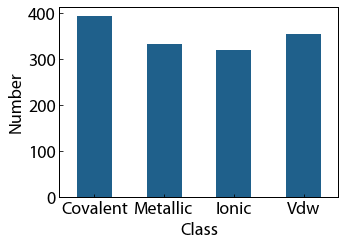

In [4]:
if 'label' in data.columns:
    y = data[['bond_length', 'label']].explode('bond_length')['label'].apply(bond_to_float).values
    fig, ax = plt.subplots(figsize=(5,3.5))
    ax.hist(y, bins=np.arange(5) - 0.25, width=0.5, color=palette[0])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number')
    ax.set_xticks(range(4))
    ax.set_xticklabels([k.capitalize() for k in bonds])
    ax.set_xlim([-0.5, 3.5])

EVR of 0.995 at 7 components


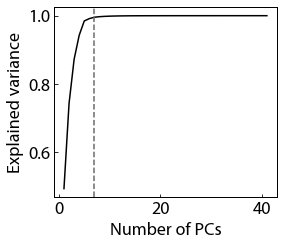

In [5]:
# compute and plot PCA summary
columns = []#['en_diff']
X = np.stack(data['elf'].sum())

for col in columns:
    X = np.hstack([X, np.expand_dims(data[col].sum(), axis=1)])

n_components = X.shape[-1]
pca = PCA(n_components=n_components, svd_solver='full')
z = pca.fit_transform(X)

# plot cumulative explained variance
plot_cevr(pca.explained_variance_ratio_, 0.995, save_path=None)

In [6]:
# calculate moments
data = calculate_moments(data)

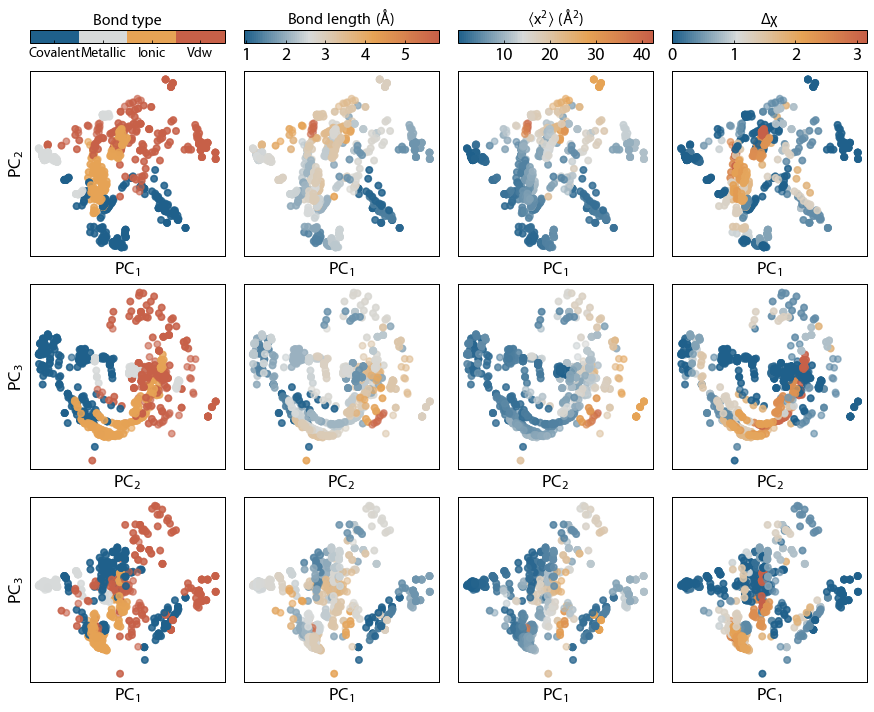

In [7]:
# plot PC projections
plot_pca(z, data, bonds, axes=[0,1,2], save_path=None)

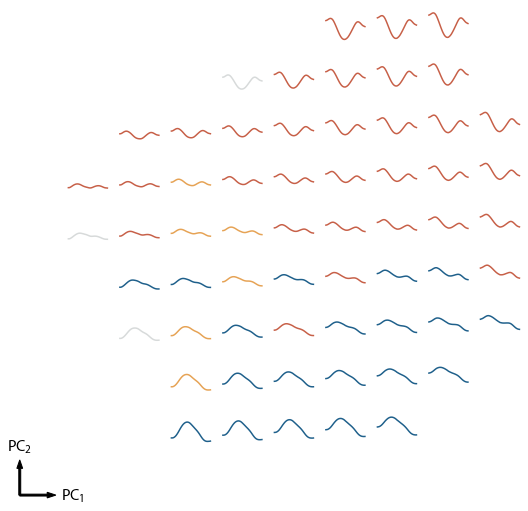

In [8]:
# plot profiles along principal axes
plot_profiles(z, data, pca, colorby='label', axes=[0,1], save_path=None)

100%|██████████| 100/100 [05:45<00:00,  3.45s/it]                               


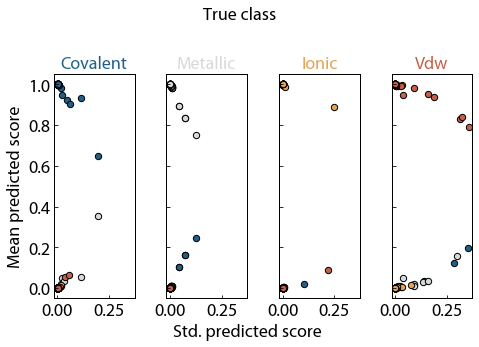

In [19]:
# train or load model
fit = True
model_path = 'models/clfs_091522_pc10_en_srt'
n_components = 10
test_size = 0.15
seed = 12
n_models = 100
early_stopping = False
columns = ['en_diff']

if fit:
    # train models
    X_data, y_data, pca, scaler = prepare_data(data, n_components, test_size, seed=seed, pca=None, scaler=None,
                                               columns=columns)
    CLFs = train_models(X_data, y_data, pca, scaler, n_models=n_models, seed=seed, early_stopping=early_stopping,
                        save_path=model_path)
    
    # plot model performance on held-out test set
    y_pred_mean = np.stack([CLFs['clfs'][i].predict_proba(X_data[1]) for i in range(n_models)]).mean(axis=0)
    y_pred_std = np.stack([CLFs['clfs'][i].predict_proba(X_data[1]) for i in range(n_models)]).std(axis=0)
    plot_scores(y_pred_mean, y_pred_std, y_data[1], save_path=None)

else:
    # load models
    CLFs = load(model_path + '.joblib')

In [20]:
# make predictions and optionally save output dataframe
data = predict(data, CLFs, columns=columns, save_path=None)

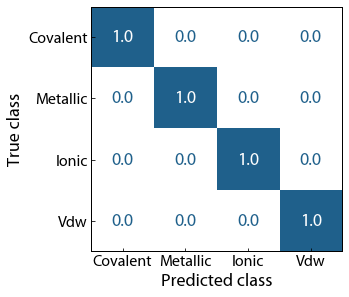

In [21]:
# plot confusion matrix
plot_confusion_matrix(data, normalize=True, save_path=None)

In [ ]:
# plot crystal graph with edges colored by predicted bond type
plot_crystal_graph(data, index=1, save_path=None)

In [22]:
# load and compare series of models
ns_components = [10,12,14] #[4,6,8,10,12]
n_models = 100
test_size = 0.15
seed = 12

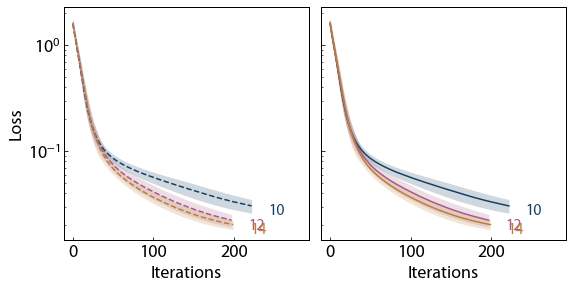

In [23]:
loss_history('091522', ns_components, columns_list=['_en','_en'], sort=True, early_stopping=False, valid=False,
             save_path=None)

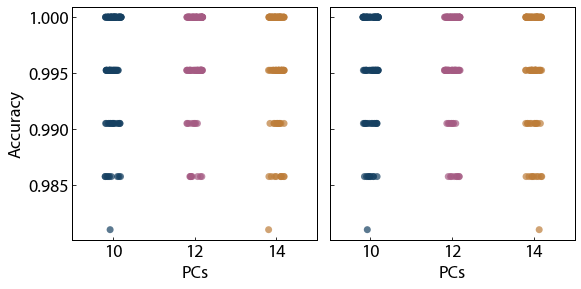

In [24]:
accuracy_stats('091522', ns_components, n_models, columns_list=['_en','_en'], sort=True, early_stopping=False,
               save_path=None)

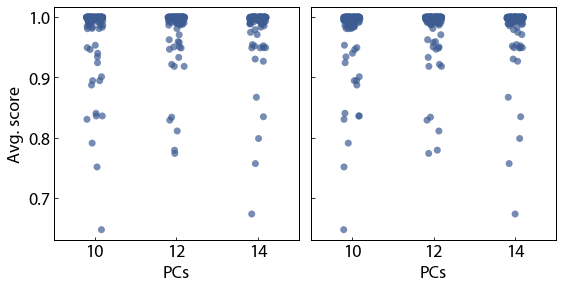

In [25]:
score_stats('091522', ns_components, data, test_size, seed, columns_list=['_en','_en'], sort=True, early_stopping=False,
            save_path=None)